In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

In [3]:
raw_dataset = pd.read_csv("cleaned_reviews.csv")
raw_dataset.drop(columns=['cleaned_review_length', 'review_score'], inplace=True)
raw_dataset.head()

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...


Preprocessing raw dataset

In [4]:
sentiments = raw_dataset['sentiments']
class_names = list(set(sentiments))
class_names

['neutral', 'positive', 'negative']

In [5]:
raw_dataset['labels'] = [class_names.index(sentiment) for sentiment in list(sentiments)]

In [6]:
raw_dataset.head()

,sentiments,cleaned_review,labels
0,positive,i wish would have gotten one earlier love it a...,1
1,neutral,i ve learned this lesson again open the packag...,0
2,neutral,it is so slow and lags find better option,0
3,neutral,roller ball stopped working within months of m...,0
4,neutral,i like the color and size but it few days out ...,0


In [7]:
dataset = raw_dataset.drop(columns=['sentiments'])
dataset.head()

,cleaned_review,labels
0,i wish would have gotten one earlier love it a...,1
1,i ve learned this lesson again open the packag...,0
2,it is so slow and lags find better option,0
3,roller ball stopped working within months of m...,0
4,i like the color and size but it few days out ...,0


Split the dataset

In [8]:
dataset.shape

(17340, 2)

In [9]:
train, val, test = np.split(dataset.sample(frac=1), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [10]:
train.head()

,cleaned_review,labels
8015,i use this mouse for work and it holds up for ...,0
7111,this is compact slim mouse wouldn call it ergo...,0
11258,na,0
7221,i was looking forward to not having to use bat...,1
12444,got these for trip and was surprised at the bu...,1


In [11]:
val.head()

,cleaned_review,labels
100,these things stop working after few weeks got ...,0
9804,i use only writing any way good,0
125,love the colors so far ok,1
12783,it works very well got it as gift for my boyfr...,1
16595,my son loves playing his music and the sound i...,1


In [12]:
test.head()

,cleaned_review,labels
2997,the item is easy to work with but honestly got...,1
4846,is very easy to manager,0
10447,used it for ps works great,1
4118,item received charger does not work,0
9876,the usb only works for the lights not for conn...,0


In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    text = list(dataframe['cleaned_review'])
    labels = list(dataframe['labels'])
    ds = tf.data.Dataset.from_tensor_slices((np.array(text), np.array(labels)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).prefetch(batch_size)
    return ds

In [14]:
raw_train_ds = df_to_dataset(train)
raw_val_ds = df_to_dataset(val)
raw_test_ds = df_to_dataset(test)

In [15]:
[(train_texts, train_labels)] = raw_train_ds.take(1)

In [16]:
print(train_texts[0].numpy())
print("="*100)
print(class_names[train_labels[0].numpy()])

b'very cheap quality but good for an emergency purchase shipping was very quick'
neutral


In [17]:
def standardization(input_text):
    text = tf.strings.lower(input_text)
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')
    return text

In [18]:
vocab_size = 10000
sequence_length = 50
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [20]:
train_texts = raw_train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_texts)

In [21]:
text_batch, label_batch = next(iter(raw_train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("Review", first_text)
print("="*120)
print("Label", first_label)
print("="*120)
print("Vectorized review\n", vectorize_layer(first_text))

Review tf.Tensor(b'my mouse stopped working within two weeks waste of money ', shape=(), dtype=string)
Label tf.Tensor(2, shape=(), dtype=int64)
Vectorized review
 tf.Tensor(
[  9  10  79  47 302 138 158 244  11 112   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


In [22]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
embedding_dim = 128
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names))
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         1280128   
                                                                 
 dropout_9 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1280515 (4.88 MB)
Trainable params: 1280515 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [48]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [49]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
434/434 [==============================] - 19s 41ms/step - loss: 0.8379 - accuracy: 0.6098 - val_loss: 0.6996 - val_accuracy: 0.7399
Epoch 2/20
434/434 [==============================] - 2s 3ms/step - loss: 0.6416 - accuracy: 0.7481 - val_loss: 0.5792 - val_accuracy: 0.7826
Epoch 3/20
434/434 [==============================] - 2s 3ms/step - loss: 0.5434 - accuracy: 0.7944 - val_loss: 0.5256 - val_accuracy: 0.7982
Epoch 4/20
434/434 [==============================] - 2s 4ms/step - loss: 0.4801 - accuracy: 0.8266 - val_loss: 0.4923 - val_accuracy: 0.8166
Epoch 5/20
434/434 [==============================] - 2s 4ms/step - loss: 0.4296 - accuracy: 0.8487 - val_loss: 0.4698 - val_accuracy: 0.8218
Epoch 6/20
434/434 [==============================] - 2s 4ms/step - loss: 0.3886 - accuracy: 0.8660 - val_loss: 0.4540 - val_accuracy: 0.8264
Epoch 7/20
434/434 [==============================] - 2s 4ms/step - loss: 0.3525 - accuracy: 0.8808 - val_loss: 0.4418 - val_accuracy: 0.8333
Epoc

In [50]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.837871,0.609789,0.699604,0.739908
1,0.641556,0.748126,0.579231,0.782584
2,0.543395,0.794406,0.525613,0.798155
3,0.480089,0.826557,0.492341,0.816609
4,0.429603,0.848688,0.469796,0.821799


<Axes: >

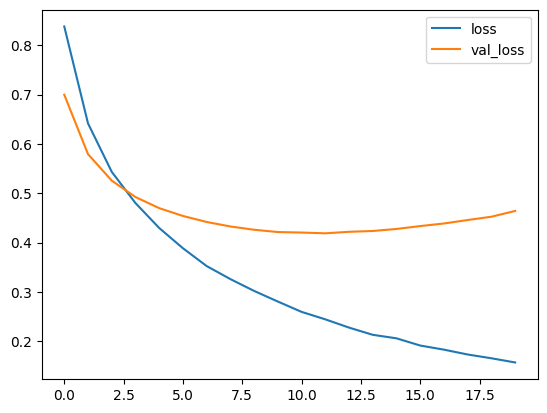

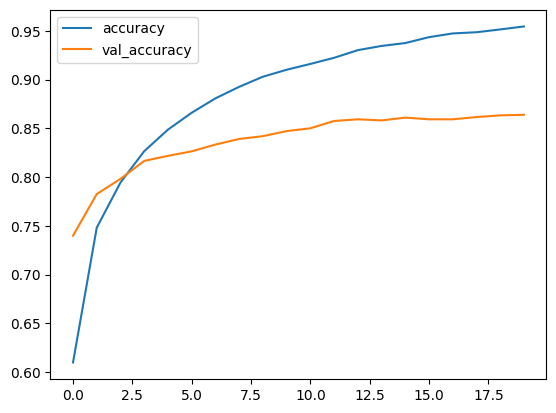

In [51]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [52]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

55/55 [==============================] - 0s 5ms/step - loss: 0.5264 - accuracy: 0.8541
Loss:  0.5263869166374207
Accuracy:  0.8540945649147034


In [53]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation("softmax")
])
model.summary()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         1280128   
                                                                 
 dropout_9 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1280515 (4.88 MB)
Trainable params: 1280515 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [54]:
test_text = raw_test_ds.map(lambda text, label: text)
test_label = export_model.predict(test_text)

55/55 [==============================] - 0s 4ms/step


In [61]:
new_reviews = [
    "not recommended",
    "Great",
    "Very Bad",
    "Not really good",
    "so bad"
]
labels = export_model.predict(new_reviews)
labels = [class_names[label.argmax()] for label in labels]
print(labels)

1/1 [==============================] - 0s 30ms/step
['neutral', 'positive', 'negative', 'neutral', 'negative']
